In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-08 16:09:35.242250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 16:09:35.242290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('../data_type.csv', parse_dates=['date'])
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

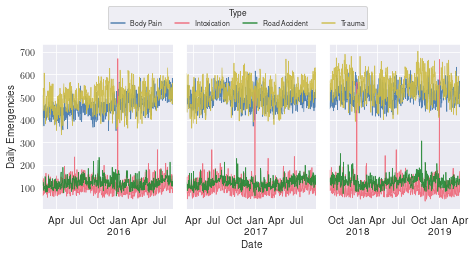

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17*cm, 8*cm), sharey=True)
axes[0].set(ylabel='Daily Emergencies')
df1.pivot_table(values="count",index="date",columns="type").plot(linewidth=.7, alpha=0.9, color=colors[0:4], legend=None, ax=axes[0], xlabel='')
df2.pivot_table(values="count",index="date",columns="type").plot(linewidth=.7, alpha=0.9,color=colors[0:4], legend=None, ax=axes[1], xlabel='Date')
df3.pivot_table(values="count",index="date",columns="type").plot(linewidth=.7, alpha=0.9,color=colors[0:4], legend=None, ax=axes[2], xlabel='')
leg = fig.legend(['Body Pain','Intoxication', 'Road Accident', 'Trauma'], title_fontsize='small', fontsize='x-small', title='Type', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
plt.tight_layout()
plt.savefig('figures/emergencies_daily_type.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [8]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [10]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input).reshape(-1, 1)
    pred = scaler.inverse_transform(pred)
    #print(x_input,pred)
    
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(actual[i:i+n_steps_in], pred, mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [11]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [12]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [13]:
df1 = df1.pivot_table('count', 'date', 'type')
df1['Total'] = df1.sum(axis=1)
dataset = df1[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset = df1[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

[0.28755367 0.15942028 0.26900584 0.125      0.665236   0.03864734
 0.40350878 0.5641892  0.416309   0.02093398 0.28654975 0.472973
 0.248927   0.03864734 0.35672516 0.695946   0.32618022 0.03220612
 0.26900584 0.6554054  0.40772533 0.03864734 0.2982456  0.6891892
 0.24034333 0.1336554  0.15789473 0.55405414] [0.1428572  0.39999998 0.28695655 0.25590062 0.2757764  0.3167702
 0.23354042] 28 7


2022-10-08 16:09:42.310874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 16:09:42.310940: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 16:09:42.310967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-08 16:09:42.311348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
16/16 [==============================] - 2s 21ms/step - loss: 0.2174
Epoch 2/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0838
Epoch 3/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0703
Epoch 4/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0685
Epoch 5/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0682
Epoch 6/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0681
Epoch 7/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0680
Epoch 8/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0682
Epoch 9/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0683
Epoch 10/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0684
Epoch 11/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0683
Epoch 12/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0677
Epoch 13/500
16/16 [=====

16/16 [==============================] - 0s 20ms/step - loss: 0.0664
Epoch 102/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0659
Epoch 103/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0663
Epoch 104/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0667
Epoch 105/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0658
Epoch 106/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0659
Epoch 107/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0660
Epoch 108/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0659
Epoch 109/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0662
Epoch 110/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0664
Epoch 111/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0662
Epoch 112/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0668
Epoch 113/500
16/1

16/16 [==============================] - 0s 18ms/step - loss: 0.0647
Epoch 200/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0650
Epoch 201/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0649
Epoch 202/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0652
Epoch 203/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0649
Epoch 204/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0651
Epoch 205/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0650
Epoch 206/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0646
Epoch 207/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0647
Epoch 208/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0649
Epoch 209/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0648
Epoch 210/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0656
Epoch 211/500
16/1

In [14]:
df2 = df2.pivot_table('count', 'date', 'type')
df2['Total'] = df2.sum(axis=1)
dataset = df2[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset = df2[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].astype('float32')
dataset_total = df2[['Total']].values
dataset_total = df2[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

[0.42213118 0.04573804 0.3272727  0.5457517  0.5204917  0.05405405
 0.22424239 0.43790853 0.34836066 0.06029107 0.22424239 0.7941177
 0.6024591  0.05613306 0.36969697 0.39215684 0.26639342 0.1954262
 0.3151515  0.2614379  0.5204917  0.2037422  0.23030299 0.22875822
 0.7459017  0.         0.13333333 0.61437917] [0.37717593 0.29013526 0.50870407 0.55319154 0.39071572 0.31334627
 0.54352033] 28 7
Epoch 1/500
16/16 [==============================] - 2s 18ms/step - loss: 0.3681
Epoch 2/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1418
Epoch 3/500
16/16 [==============================] - 0s 24ms/step - loss: 0.1180
Epoch 4/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1170
Epoch 5/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1146
Epoch 6/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1143
Epoch 7/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1151
Epoch 8/500
16/16 [=================

16/16 [==============================] - 0s 18ms/step - loss: 0.1121
Epoch 97/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1128
Epoch 98/500
16/16 [==============================] - 0s 19ms/step - loss: 0.1126
Epoch 99/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1125
Epoch 100/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1130
Epoch 101/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1131
Epoch 102/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1140
Epoch 103/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1123
Epoch 104/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1136
Epoch 105/500
16/16 [==============================] - 0s 20ms/step - loss: 0.1130
Epoch 106/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1145
Epoch 107/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1127
Epoch 108/500
16/16 [

In [15]:
df3 = df3.pivot_table('count', 'date', 'type')
df3['Total'] = df3.sum(axis=1)
dataset = df3[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset = df3[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].astype('float32')
dataset_total = df3[['Total']].values
dataset_total = df3[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

[0.2837838  0.07496012 0.25641027 0.5530547  0.17117107 0.19457734
 0.22222224 0.57877815 0.16666663 0.2200957  0.2521368  0.29903543
 0.5180179  0.07496012 0.29487184 0.52733123 0.1981982  0.07496012
 0.16239318 0.42443728 0.41891897 0.08452951 0.1752137  0.54019296
 0.59009016 0.08452951 0.24358979 0.51768494] [0.27901244 0.36296308 0.33950627 0.3308643  0.2814815  0.25061738
 0.2641976 ] 28 7
Epoch 1/500
16/16 [==============================] - 2s 17ms/step - loss: 0.2472
Epoch 2/500
16/16 [==============================] - 0s 17ms/step - loss: 0.1044
Epoch 3/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0807
Epoch 4/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0789
Epoch 5/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0784
Epoch 6/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0780
Epoch 7/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0778
Epoch 8/500
16/16 [===============

16/16 [==============================] - 0s 17ms/step - loss: 0.0772
Epoch 97/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0771
Epoch 98/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0773
Epoch 99/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0768
Epoch 100/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0770
Epoch 101/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0768
Epoch 102/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0767
Epoch 103/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0768
Epoch 104/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0767
Epoch 105/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0768
Epoch 106/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0766
Epoch 107/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0766
Epoch 108/500
16/16 [

16/16 [==============================] - 0s 17ms/step - loss: 0.0749
Epoch 195/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0747
Epoch 196/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0750
Epoch 197/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0751
Epoch 198/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0745
Epoch 199/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0746
Epoch 200/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0746
Epoch 201/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0750
Epoch 202/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0744
Epoch 203/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0747
Epoch 204/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0743
Epoch 205/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0741
Epoch 206/500
16/1

16/16 [==============================] - 0s 17ms/step - loss: 0.0709
Epoch 293/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0703
Epoch 294/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0704
Epoch 295/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0710
Epoch 296/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0707
Epoch 297/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0707
Epoch 298/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0714
Epoch 299/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0701
Epoch 300/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0702
Epoch 301/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0701
Epoch 302/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0702
Epoch 303/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0701
Epoch 304/500
16/1

16/16 [==============================] - 0s 18ms/step - loss: 0.0646
Epoch 391/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0644
Epoch 392/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0653
Epoch 393/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0657
Epoch 394/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0646
Epoch 395/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0651
Epoch 396/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0649
Epoch 397/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0649
Epoch 398/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0643
Epoch 399/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0646
Epoch 400/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0646
Epoch 401/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0643
Epoch 402/500
16/1

16/16 [==============================] - 0s 17ms/step - loss: 0.0613
Epoch 489/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0606
Epoch 490/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0613
Epoch 491/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0611
Epoch 492/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0606
Epoch 493/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0605
Epoch 494/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0609
Epoch 495/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0603
Epoch 496/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0599
Epoch 497/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0596
Epoch 498/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0595
Epoch 499/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0597
Epoch 500/500
16/1

In [16]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

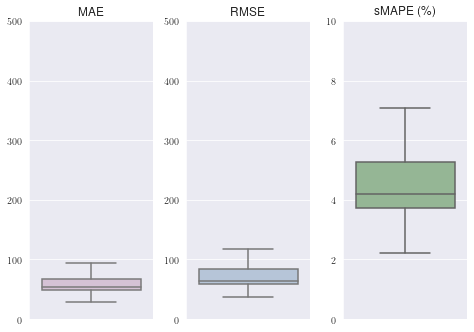

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_lstm_daily_type_boxplot.pdf')

In [19]:
emer_lstm_day_type = [mae,rmse,smape]
%store emer_lstm_day_type

Stored 'emer_lstm_day_type' (list)
